In [1]:
import os, sys
import numpy as np
import pydicom
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import h5py
import sigpy
from sigpy.mri.samp import poisson
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5, load_output, save_output, \
                            expmt_already_generated
from utils.transform import np_to_tt, split_complex_vals, recon_ksp_to_img
from utils.helpers import num_params, get_masks
from include.decoder_conv import init_convdecoder
from include.mri_helpers import get_scale_factor, get_masked_measurements, \
                                data_consistency
from include.fit import fit
from utils.evaluate import calc_metrics

if torch.cuda.is_available():
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    torch.cuda.set_device(1)
    
from utils.transform import np_to_tt, np_to_var, apply_mask, ifft_2d, fft_2d, \
                        reshape_complex_channels_to_sep_dimn, \
                        reshape_complex_channels_to_be_adj, \
                        split_complex_vals, recon_ksp_to_img

In [2]:
path = '/bmrNAS/people/arjun/data/qdess_knee_2020/files_recon_calib-16/'
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

print(len(files))

164


##### data format
- 'kspace': Nx x Ny x Nz x # echos x # coils
- 'maps': Nx x Ny x Nz x # coils x # maps
- 'target': Nx x Ny x Nz x # echos x # maps

take kspace, run on one echo. what to do w num coils? recon all, then rss at end

### load data, make mask

In [3]:
dtype = torch.cuda.FloatTensor

In [63]:
fn = files[0]
f = h5py.File(path + fn, 'r')

ksp = f['kspace']
targ = f['target']

# slice_ksp_file = ksp.value
# np.save('slice_ksp_file.npy', slice_ksp_file)
slice_ksp_file = np.load('slice_ksp_file.npy')

In [5]:
# TODO: pre-load this since it takes a long time to generate
# mask = poisson(img_shape=(512, 160), accel=4)
# mask = abs(mask)
# np.save('mask_3d.npy', mask)
mask = np.load('mask_3d.npy').astype('float32')
mask.shape

(512, 160)

In [6]:
# for faster processing, downsample slice_ksp and mask

slice_ksp_ = slice_ksp_file

C = 4 # downsample by a factor of four
i1, i2, i3 = slice_ksp_.shape[0]//2, slice_ksp_.shape[1]//2, slice_ksp_.shape[2]//2
slice_ksp_ = slice_ksp_[i1-i1//C:i1+i1//C, i2-i2//C:i2+i2//C, i3-i3//8:i3+i3//8, :, 6:10]

mask = mask[i2-i2//C:i2+i2//C, i3-i3//8:i3+i3//8]
mask.shape

(128, 20)

### for now: (1) collapse kz (2) choose one of two echos

need another version of slice_ksp, `vol_ksp`, for when we actually apply the mask. then afterward, collapse kz

In [7]:
slice_ksp_.shape # kx, ky, kz, ne, nc

(128, 128, 20, 2, 4)

In [8]:
vol_ksp = slice_ksp_[:,:,:,0,:]
vol_ksp = np.moveaxis(vol_ksp, -1, 0)
vol_ksp.shape

(4, 128, 128, 20)

In [9]:
slice_ksp = slice_ksp_[:,:,slice_ksp_.shape[2]//2,0,:]
slice_ksp = np.moveaxis(slice_ksp, -1, 0)
slice_ksp.shape

(4, 128, 128)

### follow same process as 2d case

In [10]:
print(slice_ksp.min(), slice_ksp.max(), slice_ksp.mean())
net, net_input, slice_ksp = init_convdecoder(slice_ksp, mask)
print(slice_ksp.min(), slice_ksp.max(), slice_ksp.mean())

(-156986220-31252188j) (154675800-93950376j) (155094.81-567062.1j)
(-5.966051-1.1876975j) (5.878247-3.570458j) (0.0058941706-0.021550436j)


In [11]:
# note: network has same num_params as original network w lone difference of
# 32 = 2*n_c output channels instead of 30
# hence as written now, network is agnostic to number of pixels in a slice, e.g. 512x512

# from utils.helpers import num_params
# params = [p.shape for p in net.parameters()]
# # params

In [12]:
img_gt = recon_ksp_to_img(slice_ksp, dim=128)

ksp_orig = np_to_tt(split_complex_vals(slice_ksp))[None, :].type(dtype)
ksp_orig.shape

torch.Size([1, 4, 128, 128, 2])

In [13]:
vol_ksp.shape, mask.shape

((4, 128, 128, 20), (128, 20))

In [14]:
mask_ = mask[np.newaxis, np.newaxis, :, :, np.newaxis]
# mask_ = mask_.astype(dtype)
mask_.shape, mask_.dtype

((1, 1, 128, 20, 1), dtype('float32'))

In [26]:
# need to use 3d (non-collapsed data) for this step then collapse it back down
# currently assumes vol_ksp is [16, 512, 512, 160]

# currently doing a modified version of the below function
# ksp_masked, img_masked = get_masked_measurements(vol_ksp, mask_)

ksp_masked = apply_mask(np_to_tt(vol_ksp), mask=mask_).type(torch.float32)
ksp_masked = np_to_var(ksp_masked.data.cpu().numpy()).type(dtype)
ksp_masked = ksp_masked[:, :, :, :, :, :]
ksp_masked.shape

torch.Size([1, 4, 128, 128, 20, 2])

In [16]:
# currently works only if ksp_masked is downsampled to one slice in z
img_masked = ifft_2d(ksp_masked[0]).cpu().numpy()
img_masked = reshape_complex_channels_to_be_adj(img_masked)
img_masked = np_to_var(img_masked).type(dtype)
img_masked.shape

torch.Size([1, 8, 128, 128])

In [18]:
# mask is originally 2d - use this version

# original 2d code works with the following shape outputs
# torch.Size([1, 15, 640, 372, 2]) torch.Size([1, 30, 640, 372]) (640, 372)
# with out = net(net_input) of size [1, 30, 640, 372]
# because mask is in the (x,y) plane. here mask is in the (y,z) plane
# need to sort out dimensions upstream in order to debug this

print(ksp_masked.shape, img_masked.shape, mask.shape)
net, mse_wrt_ksp, mse_wrt_img = fit(
        ksp_masked=ksp_masked, img_masked=img_masked,
        net=net, net_input=net_input, mask2d=mask, num_iter=10)

torch.Size([1, 4, 128, 128, 2]) torch.Size([1, 8, 128, 128]) (128, 20)
torch.Size([1, 8, 128, 128]) (128, 20)


RuntimeError: The size of tensor a (128) must match the size of tensor b (20) at non-singleton dimension 1

In [ ]:
sys.exit()

### how to get sampled k-space from 3d --> 2d

In [43]:
ksp_masked.shape

torch.Size([1, 4, 128, 128, 20, 2])

In [50]:
from utils.transform import fftshift, ifftshift

arr = ksp_masked[0]
print(arr.shape)

arr = ifftshift(arr, dim=(-4,-3,-2))
arr = torch.ifft(arr, signal_ndim=3) # should perform on dim=(-4,-3,-2)
arr = fftshift(arr, dim=(-4,-3,-2))

arr.shape

torch.Size([4, 128, 128, 20, 2])


torch.Size([4, 128, 128, 20, 2])

# SANITY CHECK

- given target, plot slices of 3d volume when sliced in different directions
- given k-space, reconstruct the same slices to make sure i'm doing transforms correctly

### visualize fully-sampled data

In [ ]:
def plot_slices(vol):
    ''' given 3D array vol, plot slices of first dimn by first four cols '''
    
    num_cols = 4
    num_rows = len(vol) // num_cols
    
    fig = plt.figure(figsize=(10*num_cols,10*num_rows))

    for idx, img in enumerate(vol):
        ax = fig.add_subplot(num_rows, num_cols, idx+1)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        plt.tight_layout()

### plot original image

In [99]:
targ.shape

(512, 512, 160, 2, 1)

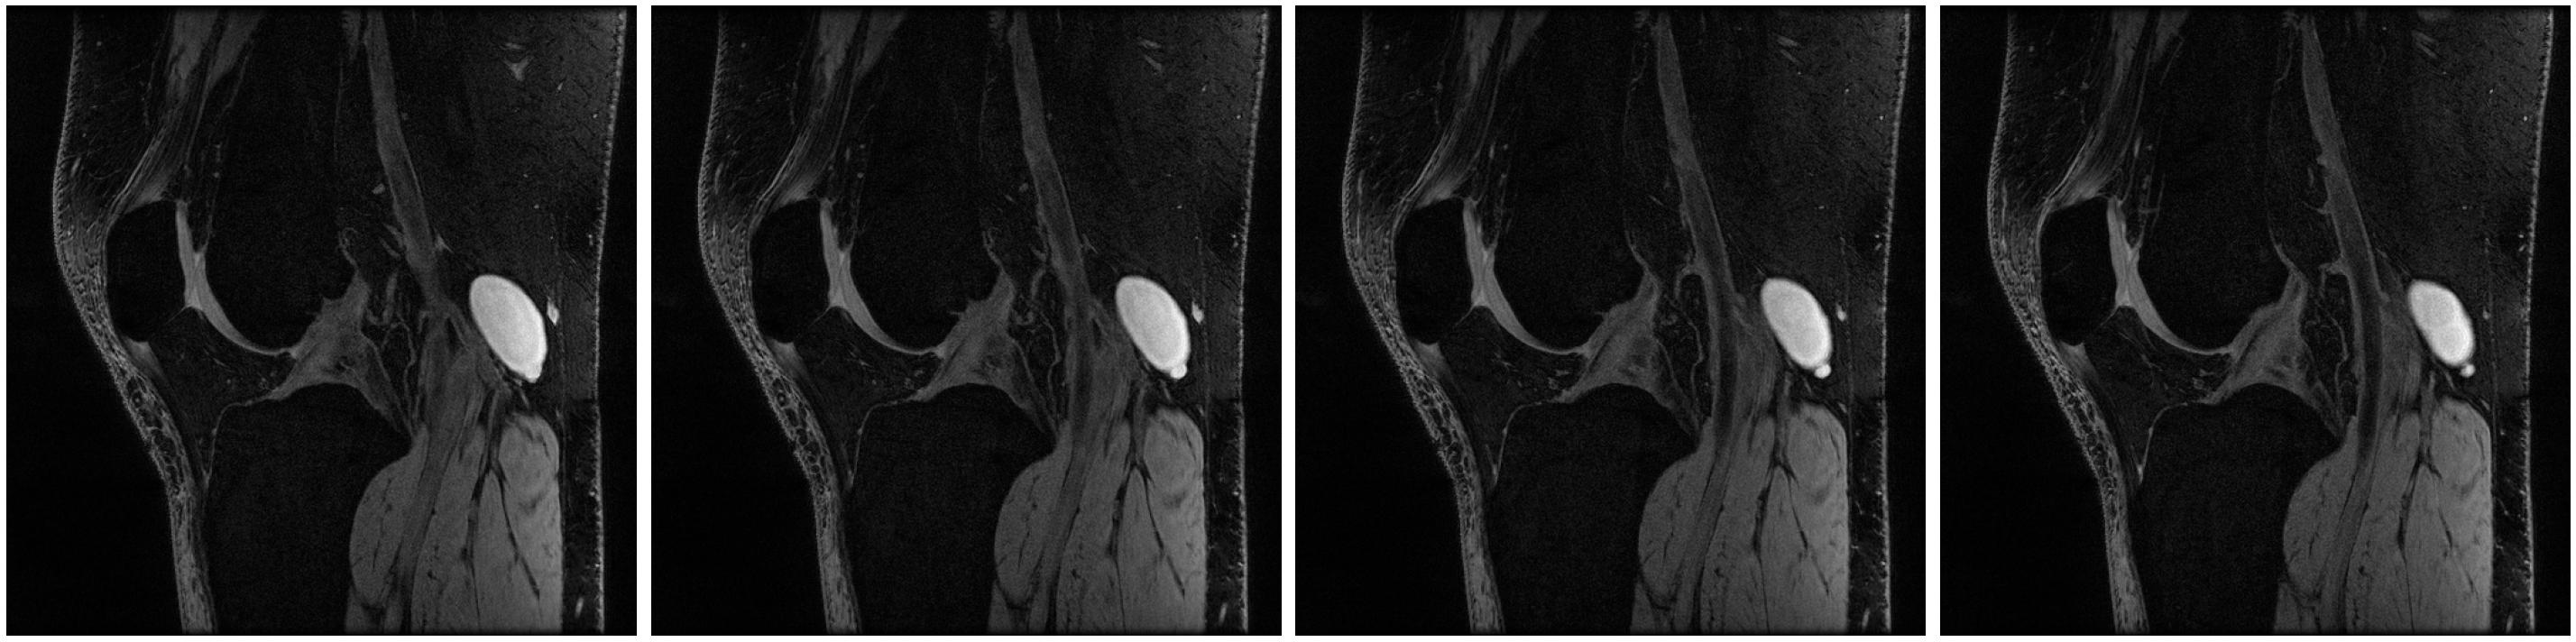

In [72]:
targ_mid = abs(np.moveaxis(targ[:,:,78:82,0,0], -1, 0))

plot_slices(targ_mid)

### do ifft on fully sampled k-space and construct the gt

In [100]:
slice_ksp_file.shape

(512, 512, 160, 2, 16)

In [110]:
ss = slice_ksp_file
ss = ss[:, :, :, 0, :] # select one of the echos
ss.shape

(512, 512, 160, 16)

In [111]:
ss = np.moveaxis(ss, -2, 0)
ss = np.moveaxis(ss, -1, 0)
ss.shape

(16, 160, 512, 512)

In [122]:
ss_ = np.array([np.real(ss), np.imag(ss)]).transpose(1,2,3,4,0)
ss_ = torch.from_numpy(ss_)
ss_.shape

torch.Size([16, 160, 512, 512, 2])

In [135]:
# NOTE: i get a different result when doing shift before/after than just doing ifft
# include normalized or not?

ss_img = ifftshift(ss_, dim=(-4,-3,-2))
ss_img = torch.ifft(ss_img, 3, normalized=True)
ss_img = fftshift(ss_img, dim=(-4,-3,-2))

# ss_img = torch.ifft(ss_, 3)

ss_img.shape

torch.Size([16, 160, 512, 512, 2])

In [136]:
# combine complex channels
ss_img = torch.sqrt(torch.sum(torch.square(ss_img), axis=-1)) 
ss_img.shape

torch.Size([16, 160, 512, 512])

In [137]:
# combine coils via rss
ss_img = torch.sqrt(torch.sum(torch.square(ss_img), axis=0)) 
ss_img.shape

torch.Size([160, 512, 512])

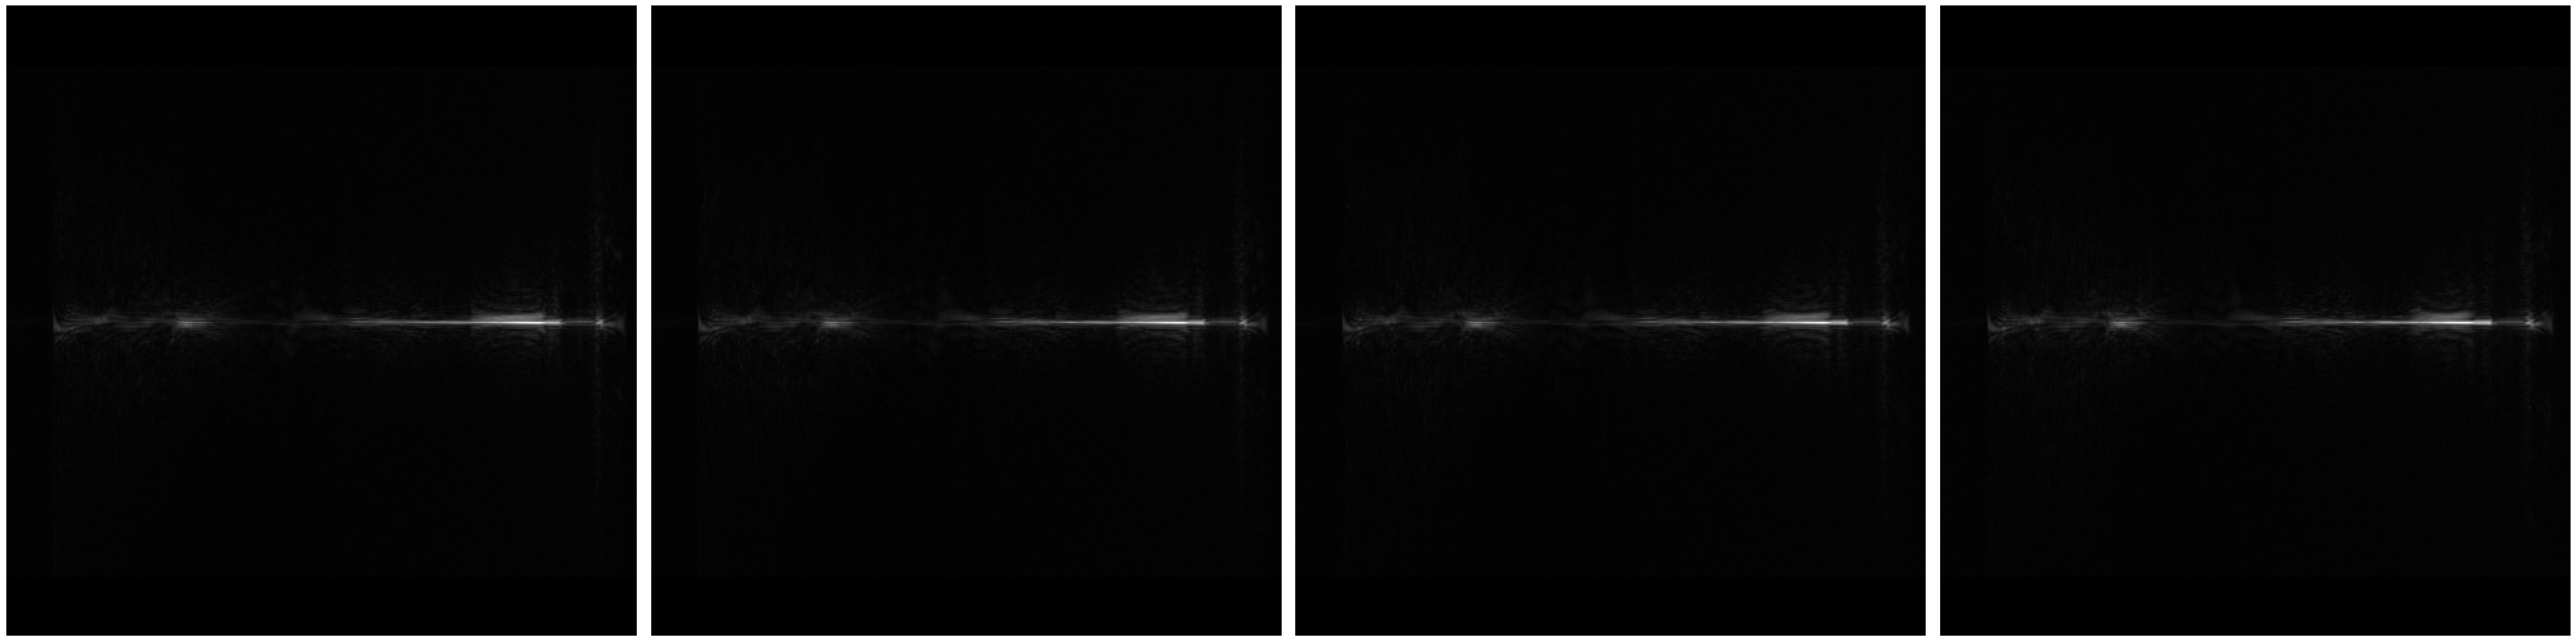

In [138]:
ss_mid = ss_img[78:82] # get central four slices
plot_slices(ss_mid)

### toy example of arr * mask

In [ ]:
m4 = abs(poisson(img_shape=(5,4), accel=2))
m4

In [ ]:
ksp_t = np.ones((5,5,4,2,6), dtype=np.complex64)
ksp_t.shape

In [ ]:
m4_ = m4[np.newaxis, :, :, np.newaxis, np.newaxis]
m4_.shape

In [ ]:
out = ksp_t * m4_
out.shape

In [ ]:
num_cols = 4
num_rows = len(tt) // num_cols
fig = plt.figure(figsize=(10*num_cols,10*num_rows))

for idx, img in enumerate(tt):#num_rows*num_cols]):
#     print(img.min(), img.max())
    ax = fig.add_subplot(num_rows, num_cols, idx+1)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    plt.tight_layout()

In [ ]:
plt.imshow(tt, cmap='gray')

In [ ]:
path = '/bmrNAS/people/akshay/dicoms/philips_ge/ge_042719/5889_04272019/001/'
files = [f for f in listdir(path) if isfile(join(path, f))]
files.sort()

print(len(files))

In [ ]:
vol_img = []

for f in files:

    dcm = pydicom.dcmread(path + f)
    vol_img.append(dcm.pixel_array)